In [1]:
import ee
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

In [513]:
MODEL_INFO = {'UKESM1-0-LL': 'HadAM',
 'NorESM2-MM': 'CCM',
 'NorESM2-LM': 'CCM',
 'MRI-ESM2-0': 'UCLA GCM',
 'MPI-ESM1-2-LR': 'ECMWF',
 'MPI-ESM1-2-HR': 'ECMWF',
 'MIROC6': 'MIROC',
 'MIROC-ES2L': 'MIROC',
 'KIOST-ESM': 'GFDL',
 'KACE-1-0-G': 'HadAM',
 'IPSL-CM6A-LR': 'IPSL',
 'INM-CM5-0': 'INM',
 'INM-CM4-8': 'INM',
 'HadGEM3-GC31-MM': 'HadAM',
 'HadGEM3-GC31-LL': 'HadAM',
 'GFDL-ESM4': 'GFDL',
 'GFDL-CM4_gr2': 'GFDL',
 'GFDL-CM4': 'GFDL',
 'FGOALS-g3': 'CCM',
 'EC-Earth3-Veg-LR': 'ECMWF',
 'EC-Earth3': 'ECMWF',
 'CanESM5': 'CanAM',
 'CNRM-ESM2-1': 'ECMWF',
 'CNRM-CM6-1': 'ECMWF',
 'CMCC-ESM2': 'CCM',
 'CMCC-CM2-SR5': 'CCM',
 'BCC-CSM2-MR': 'CCM',
 'ACCESS-ESM1-5': 'HadAM',
 'ACCESS-CM2': 'HadAM',
 'TaiESM1': 'CCM',
}

EXCLUDED_MODELS = ['GFDL-CM4_gr2','ERA5']

MODELS = [i for i in MODEL_INFO.keys() if not i in EXCLUDED_MODELS]


INITIAL_LATLON = (-1.286389, 36.817223)  # Nairobi

HIST_START = 1980
HIST_END = 2014
FUTURE_START = 2050
FUTURE_END = 2070

STUDY_THRESH = 40

NUM_BEST_MODELS = 3

shift_years = False

In [3]:
def d2j(datestring):
    d = datetime.date.fromisoformat(datestring)
    jday = d.timetuple().tm_yday
    if calendar.isleap(d.year) and jday > 59:
        jday -= 1
    return jday

In [4]:
def runs(tf_array, min_runsize, result_type=None):
    falses = np.zeros(tf_array.shape[0]).reshape((tf_array.shape[0],1))
    extended_a = np.concatenate((falses, tf_array, falses), axis=1)
    df = np.diff((extended_a), axis=1)
    starts = np.nonzero(df == 1)
    ends = np.nonzero(df == -1)
    lengths = {i: [] for i in range(tf_array.shape[0] + 1)}
    indices = {i: [] for i in range(tf_array.shape[0] + 1)}
    if starts[0].size > 0:
        for idx in range(starts[0].size):
            length = ends[1][idx] - starts[1][idx]
            if length >= min_runsize:
                lengths[starts[0][idx]].append(ends[1][idx] - starts[1][idx])
                indices[starts[0][idx]].append((ends[1][idx], starts[1][idx]))
        lengths_vals = lengths.values()
    else:
        lengths_vals = []
    result = []
    
    if result_type == 'maxlength':
        for ll in lengths.values():
            if ll:
                result.append(np.max(ll))
            else:
                result.append(0)
    elif result_type == 'minlength':
        for ll in lengths.values():
            if ll:
                result.append(np.min(ll))
            else:
                result.append(0)
    elif result_type == 'meanlength':
        for ll in lengths.values():
            if ll:
                result.append(np.mean(ll))
            else:
                result.append(0)
    elif result_type == 'medianlength':
        for ll in lengths.values():
            if ll:
                result.append(np.median(ll))
            else:
                result.append(0)
    elif result_type == 'count':
        for ll in lengths.values():
            if ll:
                result.append(len(ll))
            else:
                result.append(0)
    elif result_type == 'indices':
        result = indices
    else:
        result = lengths
    
    return result

In [5]:
def get_var(varname, model, latlon, start_year=HIST_START, end_year=HIST_END, yearshift=False, scenario='ssp585'):
    def removeLeapDays(arr, yearshift=False):
        if not yearshift:
            indices = []
            jan1_idx = 0
            for year in range(start_year, end_year+1):
                indices += [jan1_idx + i for i in range(365)]
                jan1_idx += 365
                if calendar.isleap(year):
                    jan1_idx += 1
            return arr[indices]
        else:
            indices = []
            jul1_idx = 0
            for year in range(start_year-1, end_year):
                indices += [jul1_idx + i for i in range(183)]
                jul1_idx += 183
                if calendar.isleap(year):
                    jul1_idx += 1
                indices += [jul1_idx + i for i in range(182)]
                jul1_idx += 182
            return arr[indices]
    if model != 'ERA5' and start_year < 2015 and end_year >= 2015:
        raise Exception("Requesting hist and non-hist variables in one query")
    if model == 'ERA5':
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
    else:
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(end_year<2015)]))
    gee_geom = ee.Geometry.Point((latlon[1], latlon[0]))
    if not yearshift:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), False)
    else:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-07-01'.format(start_year-1), '{0}-07-01'.format(end_year)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), True)

In [378]:
def quarters(d, start_year, end_year):
    mam = []  # 60-151
    jja = []  # 152-243
    son = []  # 244-334
    djf = []  # 335-59
    jan1_idx = 365# + [0, 1][int(calendar.isleap(start_year))]
    for year in range(start_year, end_year):
        tmp = np.concatenate((d[jan1_idx - 365 : jan1_idx - 365 + 60], d[jan1_idx + 335 : jan1_idx + 365]), axis=0)
        djf.append(tmp)
        mam.append(d[jan1_idx + 60 : jan1_idx + 152])
        jja.append(d[jan1_idx + 152 : jan1_idx + 244])
        son.append(d[jan1_idx + 244 : jan1_idx + 335])

        jan1_idx += 365 + [0, 0][int(False and calendar.isleap(year))]
    mam_res = np.vstack(mam)
    jja_res = np.vstack(jja)
    son_res = np.vstack(son)
    djf_res = np.vstack(djf)
    return mam_res, jja_res, son_res, djf_res
    
def seasonal_means(d):
    q = quarters(d, HIST_START, HIST_END)
    return np.array([np.mean(q[0], axis=1), np.mean(q[1], axis=1), np.mean(q[2], axis=1), np.mean(q[3], axis=1)])

In [7]:
def get_rmsd(d1, d2):
    c1 = seasonal_means(d1)
    c2 = seasonal_means(d2)
    return np.sqrt(np.mean(np.sum((c1 - c2)**2)))

In [17]:
def calibration_function(hist_obs, hist_mod):
    source = np.sort(hist_obs.flatten())
    target= np.sort(hist_mod.flatten())
   
    if (np.max(source) == 0 and np.min(source) == 0):
        return np.arange(0, target.size) / target.size
    if (np.max(target) == 0 and np.min(target) == 0):
        return np.arange(0, source.size) / source.size
    new_indices = []
    #source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        if target_idx < len(source):
            source_value = source[target_idx]
            if source_value > target[-1]:
                new_indices.append(target.size - 1)
            else:
                new_indices.append(np.argmax(target >= source_value))
    return np.array(new_indices) / source.size

In [161]:
# Select three best models based on RMSD of quarterly mean precip
hist_obs = get_var('total_precipitation', 'ERA5', INITIAL_LATLON, yearshift=shift_years)
hist_mods = {}
rmsds = []
for model in MODELS:
    hist_mod = get_var('pr', model, INITIAL_LATLON, start_year=HIST_START)
    hist_mods[model] = hist_mod
    rmsds.append((get_rmsd(hist_obs, hist_mod), model))
rmsds.sort()
best_models = []
families = []
idx = 0
while len(best_models) < 3:
    if not MODEL_INFO[rmsds[idx][1]] in families:
        best_models.append(rmsds[idx][1])
        families.append(MODEL_INFO[rmsds[idx][1]])
    idx += 1
    
for m in best_models:
    print(m, [i[0] for i in rmsds if i[1]==m][0])

MRI-ESM2-0 0.026260314391805685
IPSL-CM6A-LR 0.026264631961995466
HadGEM3-GC31-MM 0.026272448937212225


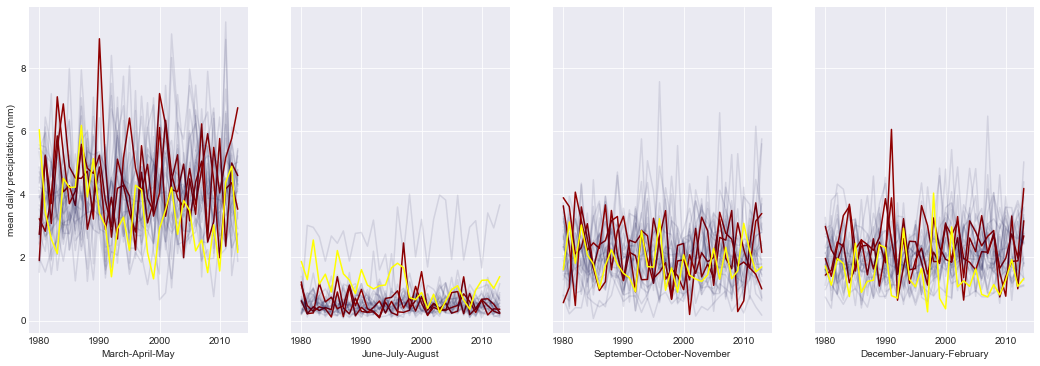

<Figure size 648x288 with 0 Axes>

In [380]:
fig, (mam, jja, son, djf) = plt.subplots(1, 4, sharey=True, figsize=(18, 6))
plt.figure(figsize=(9,4))
for season in range(4):
    ax = [mam, jja, son, djf][season]
    for model in hist_mods:
        ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_mods[model] * 86400)[season], color=['#000040', '#900000'][int(model in best_models)], alpha=[0.1, 1][int(model in best_models)])
    ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_obs)[season], color="#ffff00")
    if season == 0:
        ax.set_ylabel('mean daily precipitation (mm)')
    ax.set_xlabel(['March-April-May', 'June-July-August', 'September-October-November', 'December-January-February'][season])

In [430]:
for quarter in range(4):
    obs_10 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[quarter], 10)
    obs_90 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[quarter], 90)
    for model in best_models:
        mod = quarters(hist_mod[model], HIST_START, HIST_END)[quarter].flatten()
        print('{0}: min modeled value does not exceed observed 10th percentile  {1}'.format(model, min(mod) <= obs_10))
        print('{0}: max modeled value does not exceed observed 90th percentile  {1}'.format(model, max(mod) >= obs_90))


MRI-ESM2-0: min modeled value does not exceed observed 10th percentile  True
MRI-ESM2-0: max modeled value does not exceed observed 90th percentile  True
IPSL-CM6A-LR: min modeled value does not exceed observed 10th percentile  True
IPSL-CM6A-LR: max modeled value does not exceed observed 90th percentile  True
HadGEM3-GC31-MM: min modeled value does not exceed observed 10th percentile  True
HadGEM3-GC31-MM: max modeled value does not exceed observed 90th percentile  True
MRI-ESM2-0: min modeled value does not exceed observed 10th percentile  True
MRI-ESM2-0: max modeled value does not exceed observed 90th percentile  True
IPSL-CM6A-LR: min modeled value does not exceed observed 10th percentile  True
IPSL-CM6A-LR: max modeled value does not exceed observed 90th percentile  True
HadGEM3-GC31-MM: min modeled value does not exceed observed 10th percentile  True
HadGEM3-GC31-MM: max modeled value does not exceed observed 90th percentile  True
MRI-ESM2-0: min modeled value does not exceed ob

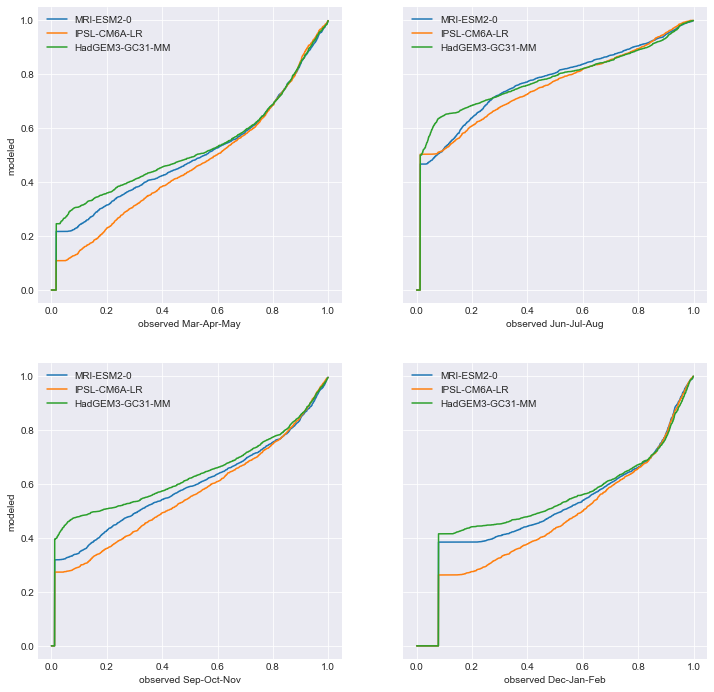

In [411]:
# Get precip calibration functions

calibration_fxn = {}
hist_mod = {}

hist_obs = get_var('total_precipitation', 'ERA5', INITIAL_LATLON) * 1000
#plt.figure(figsize=(12, 2.5))
for model in best_models:
    hist_mod[model] = get_var('pr', model, INITIAL_LATLON, yearshift = shift_years) * 86400
    o_quarters = quarters(hist_obs, HIST_START, HIST_END)
    m_quarters = quarters(hist_mod[model], HIST_START, HIST_END)
    calibration_fxn[model] = [calibration_function(o_quarters[i].flatten(), m_quarters[i].flatten()) for i in range(4)]
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
for i in range(4):
    ax = (ax0, ax1, ax2, ax3)[i]
    for model in best_models:
        ax.plot([j/(len(calibration_fxn[model][i])+1) for j in range(len(calibration_fxn[model][i]))], calibration_fxn[model][i], label=model)
        ax.set_xlabel('observed {}'.format(['Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov', 'Dec-Jan-Feb'][i]))
        ax.legend()
ax0.set_ylabel('modeled')
ax2.set_ylabel('modeled')
plt.show()

In [514]:
fut_mod = {}
for model in best_models:
    fut_mod[model] = get_var('pr', model, INITIAL_LATLON, start_year=FUTURE_START, end_year=FUTURE_END, yearshift=shift_years) * 86400

In [522]:
def calibrate_component(uncalibrated_data, calibration_fxn):
    N = len(uncalibrated_data)
    unsorted_uncalib = [(i, idx) for idx, i in enumerate(uncalibrated_data)]
    sorted_uncalib = sorted(unsorted_uncalib)
    result = [0] * N
    for j in range(N):
        X_j = j / (N + 1)
        Y_jprime = calibration_fxn[math.floor(X_j * len(calibration_fxn))]
        jprime = math.floor(Y_jprime * (N + 1))
        result[sorted_uncalib[j][1]] = sorted_uncalib[min(len(sorted_uncalib)-1, jprime)][0]
    
    return result

def calibrate(uncalibrated_data, calibration_fxn):
    mam = []
    jja = []
    son = []
    djf = []
    mam_idx = []
    jja_idx = []
    son_idx = []
    djf_idx = []
    for idx, i in enumerate(uncalibrated_data):
        if idx % 365 >= 60 and idx % 365 < 152:
            mam.append(uncalibrated_data[idx])
            mam_idx.append(idx)
        elif idx % 365 >= 152 and idx % 365 < 244:
            jja.append(uncalibrated_data[idx])
            jja_idx.append(idx)
        elif idx % 365 >= 244 and idx % 365 < 335:
            son.append(uncalibrated_data[idx])
            son_idx.append(idx)
        else:
            djf.append(uncalibrated_data[idx])
            djf_idx.append(idx)
    
    mam_calib = calibrate_component(np.array(mam), calibration_fxn[0])
    jja_calib = calibrate_component(np.array(jja), calibration_fxn[1])
    son_calib = calibrate_component(np.array(son), calibration_fxn[2])
    djf_calib = calibrate_component(np.array(djf), calibration_fxn[3])
    
    result = [0] * len(uncalibrated_data)
    for i in range(len(mam_idx)):
        result[mam_idx[i]] = mam_calib[i]
    for i in range(len(jja_idx)):
        result[jja_idx[i]] = jja_calib[i]
    for i in range(len(son_idx)):
        result[son_idx[i]] = son_calib[i]
    for i in range(len(djf_idx)):
        result[djf_idx[i]] = djf_calib[i]

    return np.array(result)
    

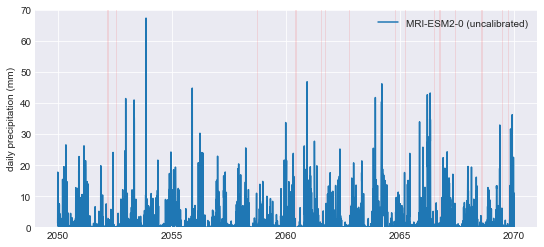

In [517]:
# Plot future modeled time series of UNCALIBRATED precip

plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*20)], fut_mod[model][:-365], label='{0} (uncalibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(0,70)
run_indices = runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = FUTURE_START + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan((year+0)+((ii[1] - [0, 182][int(shift_years)])/365), (year+0)+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.ylabel('daily precipitation (mm)')
plt.legend(loc='upper right')
plt.show()

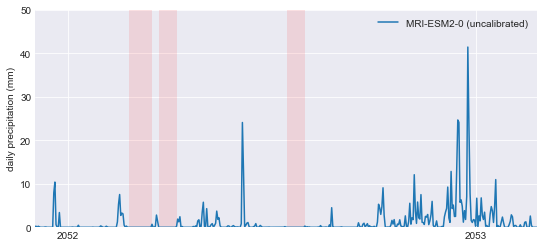

In [519]:
# Plot close-up
plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*20)], fut_mod[model][:-365], label='{0} (uncalibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 1 == 0])
plt.ylim(0,50)
plt.xlim(2050+(700/365),2050+(1150/365))
run_indices = runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = FUTURE_START + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan((year+0)+((ii[1] - [0, 182][int(shift_years)])/365), (year+0)+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.legend(loc='upper right')
plt.ylabel('daily precipitation (mm)')
plt.show()

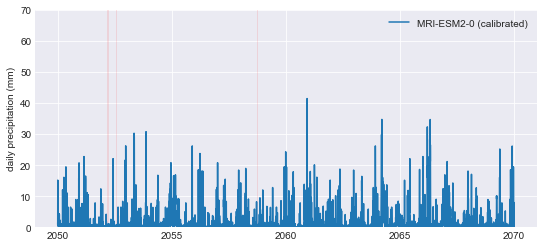

In [523]:
# Plot future modeled time series of CALIBRATED tasmax
plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*20)], calib_data[:-365], label='{0} (calibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+2) if y % 5 == 0])
plt.ylim(0, 70)
#plt.xlim(2050+(750/365),2050+(900/365))
run_indices = runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = 2050 + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan((year+0)+((ii[1] - [0, 182][int(shift_years)])/365), (year+0)+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.legend(loc='upper right')
plt.ylabel('daily precipitation (mm)')
plt.show()

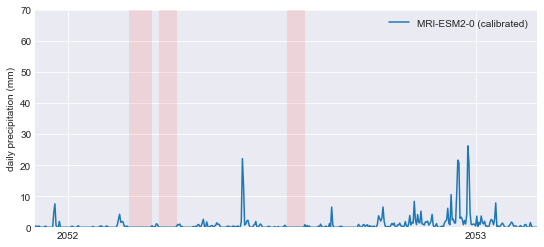

In [524]:
# closeup calibrated
plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*20)], calib_data[:-365], label='{0} (calibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 1 == 0])
plt.ylim(0, 70)
plt.xlim(2050+(700/365),2050+(1150/365))

#plt.xlim(2050+(750/365),2050+(900/365))
run_indices = runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = 2050 + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan((year+0)+((ii[1] - [0, 182][int(shift_years)])/365), (year+0)+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.legend(loc='upper right')
plt.ylabel('daily precipitation (mm)')
plt.show()

In [492]:
for model in list(fut_mod.keys()):
    #calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    a = np.sum(runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))
    print(model, a)

MRI-ESM2-0 17
IPSL-CM6A-LR 16
HadGEM3-GC31-MM 5


In [525]:
for model in list(fut_mod.keys()):
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    a = np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))
    print(model, a)

MRI-ESM2-0 4
IPSL-CM6A-LR 5
HadGEM3-GC31-MM 1


In [494]:
def get_gamma(count, size):
    return np.random.gamma(shape = count + 0.5, size=size)

In [526]:
posterior_lambdas = {}
for model in fut_mod:
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    count = np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365))  == 0, 15, 'count'))
    posterior_lambdas[model] = get_gamma(count, 10000)

In [496]:
poisson_draws = {}
for model in posterior_lambdas:
    poisson_draws[model] = np.random.poisson(posterior_lambdas[model], 10000)

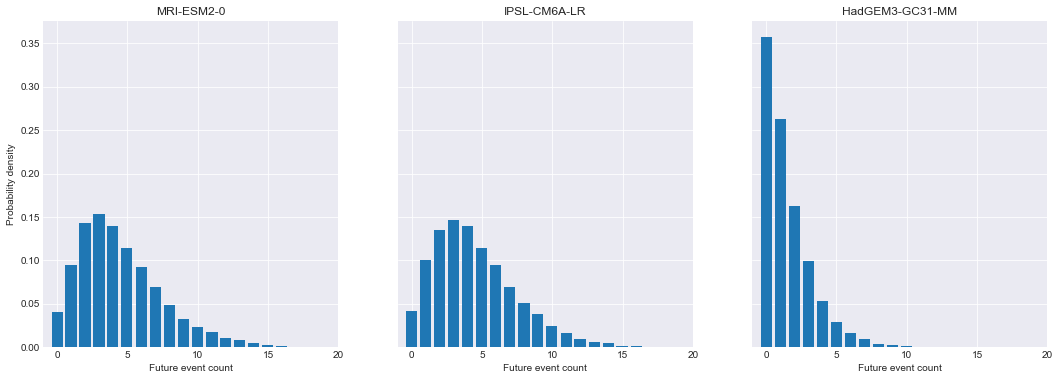

In [497]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
hist = np.histogram(poisson_draws[list(poisson_draws.keys())[0]], bins=400)
hist0 = ax0.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax0.set_title(list(poisson_draws.keys())[0])
ax0.set_xticks([i for i in range(50) if i % 5 == 0])
hist = np.histogram(poisson_draws[list(poisson_draws.keys())[1]], bins=400)
hist1 = ax1.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax1.set_title(list(poisson_draws.keys())[1])
ax1.set_xticks([i for i in range(50) if i % 5 == 0])
hist = np.histogram(poisson_draws[list(poisson_draws.keys())[2]], bins=400)
hist2 = ax2.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax2.set_title(list(poisson_draws.keys())[2])
ax2.set_xticks([i for i in range(50) if i % 5 == 0])
ax0.set_xlim((-1,20))
ax1.set_xlim((-1,20))
ax2.set_xlim((-1,20))
ax0.set_ylabel('Probability density')
ax0.set_xlabel('Future event count')
ax1.set_xlabel('Future event count')
ax2.set_xlabel('Future event count')
plt.show()

In [498]:
for model in poisson_draws:
    print('{0}: {1}'.format(model, np.sum(poisson_draws[model]) / 10000))

MRI-ESM2-0: 4.5171
IPSL-CM6A-LR: 4.5342
HadGEM3-GC31-MM: 1.4879


In [444]:
obs_90

3.5752300173044196

In [443]:
obs_90

3.5752300173044196

In [446]:
max(quarters(hist_mod[model], HIST_START, HIST_END)[quarter].flatten())

48.38905055075884

In [453]:
with open('overlaps_n.csv', 'w') as ofile:
    ofile.write('obs_10,obs_90,')
    ofile.write(','.join(['min_{0},max_{0}'.format(m) for m in best_models]))
    ofile.write('\n')
    for quarter in range(4):
        obs_10 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[quarter], 10)
        obs_90 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[quarter], 90)
        ofile.write(','.join([str(obs_10), str(obs_90)]))
        ofile.write(',')
        for model in best_models:
            mod = quarters(hist_mod[model], HIST_START, HIST_END)[quarter].flatten()
            ofile.write(','.join([str(min(mod)), str(max(mod))]))
            ofile.write(',')
        ofile.write('\n')

In [451]:
','.join(['min_{0},max_{0}'.format(m) for m in best_models])

'min_MRI-ESM2-0,max_MRI-ESM2-0,min_IPSL-CM6A-LR,max_IPSL-CM6A-LR,min_HadGEM3-GC31-MM,max_HadGEM3-GC31-MM'

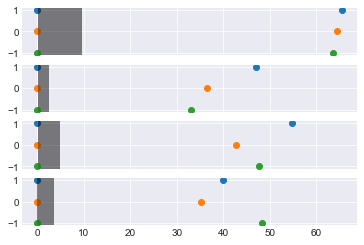

In [469]:
ys = {best_models[i]: 1-i for i in range(3)}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
obs_10 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[0], 10)
obs_90 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[0], 90)
for model in best_models:
    mod = quarters(hist_mod[model], HIST_START, HIST_END)[0].flatten()
    s1 = ax1.scatter([min(mod), max(mod)], [ys[model], ys[model]])
    r1 = ax1.axvspan(obs_10, obs_90, facecolor='black', alpha=0.2)
    
obs_10 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[1], 10)
obs_90 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[1], 90)
for model in best_models:
    mod = quarters(hist_mod[model], HIST_START, HIST_END)[1].flatten()
    s2 = ax2.scatter([min(mod), max(mod)], [ys[model], ys[model]])
    r2 = ax2.axvspan(obs_10, obs_90, facecolor='black', alpha=0.2)
    
obs_10 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[2], 10)
obs_90 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[2], 90)
for model in best_models:
    mod = quarters(hist_mod[model], HIST_START, HIST_END)[2].flatten()
    s3 = ax3.scatter([min(mod), max(mod)], [ys[model], ys[model]])
    r3 = ax3.axvspan(obs_10, obs_90, facecolor='black', alpha=0.2)
    
obs_10 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[3], 10)
obs_90 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[3], 90)
for model in best_models:
    mod = quarters(hist_mod[model], HIST_START, HIST_END)[3].flatten()
    s4 = ax4.scatter([min(mod), max(mod)], [ys[model], ys[model]])
    r4 = ax4.axvspan(obs_10, obs_90, facecolor='black', alpha=0.2)